# 07 Väärinfo mudelid

Inspiratsioon ja algallikad:
1. Fake news detector
https://www.kaggle.com/rodolfoluna/fake-news-detector
2. Fake and real news dataset
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
3. https://github.com/DARIAH-DE/tatom/tree/develop/source
4. Classification of text documents using sparse features
https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html
5. KNN Classification using Scikit-learn
https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034349&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9061567&gclid=CjwKCAiA-_L9BRBQEiwA-bm5fmXHZ5wjftR4hIRqhltZGr54molVq8Rf41i21I7aOOhgxu9MTO2FhBoCfSQQAvD_BwE
6. Text classification using K Nearest Neighbors (KNN)
https://iq.opengenus.org/text-classification-using-k-nearest-neighbors/
7. Text Classification with Python and Scikit-Learn
https://stackabuse.com/text-classification-with-python-and-scikit-learn/
8. Advanced Python Project – Detecting Fake News with Python (PassiveAggressiveClassifier)
https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/
9. How to Use Tfidftransformer & Tfidfvectorizer?
https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.X9EGg2gzZPZ
10. Latent Dirichlet Allocation
https://radimrehurek.com/gensim/models/ldamodel.html
11. How Naive Bayes Algorithm Works? (with example and full code)
https://www.machinelearningplus.com/predictive-modeling/how-naive-bayes-algorithm-works-with-example-and-full-code/#9buildingnaivebayesclassifierinpython

Eesmärk on leida masinõppemeetoditega mudel, mis oskaks ennustada, kas etteantud uudis on tõene või vale. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
from estnltk import Text
from tqdm import tqdm
import re
from estnltk.wordnet import Wordnet
import seaborn as sns
#from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
fake = pd.read_csv("fake.csv")
true = pd.read_csv("true.csv")
print("Väärinfo uudised: ", fake.shape)
print("Tõeseid uudiseid: ", true.shape)

Väärinfo uudised:  (100, 5)
Tõeseid uudiseid:  (100, 5)


Mudelite koostamiseks kasutatakse märgendatud andmestikke. Iga uudisartikli kohta on kuus andmevälja:

pealkiri

uudise tekst

väljaandja

publitseerimise kuupäev

artikli link

märgendus (tõene või väär)

In [3]:
#Väärinfo ja tõese info eristamine
fake['target'] = 'fake'
true['target'] = 'true'
# andmestike ühendamine
data = pd.concat([fake, true]).reset_index(drop = True)
print("Uudiseid: ", data.shape)

Uudiseid:  (200, 6)


In [4]:
# Andmestiku segamine
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [5]:
# Ebavajaliku info  (aeg, pealkiri) eemaldamine
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)
data.drop(["subject"],axis=1,inplace=True)
data.drop(["link"],axis=1,inplace=True)

In [6]:
data['text'] = data['text'].astype(str)

Stoppsõnadena on kasutusel sidesõnad ja sidesõnad koos asesõnadega.

In [7]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju', '-']

# Veamaatriks, segadusmaatriks (confusion matrix)

Veamaatriks väljendab saadud mudeli headust. Maatriksi peadiagonaalil asetsevad kõik klassifikaatori pool õigesti ennustatud väärtused: õiged positiivsed, õiged negatiivsed. Kõik, mis jääb peadiagonaalilt välja, on väärad: vale positiivsed, vale negatiivsed. Mida rohkem õigeid negatiivseid ja õigeid positiivseid tulemusi, seda parem mudel. 

                  Väär  | õige negatiivne    | vale positiivne
                  _______________________________________________          Tegelik märgend
                  
                  Tõene | vale negatiivne    | õige positiivne
                  _______________________________________________
                              Väär                Tõene
                  
                                Ennustatud märgend
   
                    

Veamaatriksi visuaalne esitus

In [8]:
# Veamaatriks (plot the confusion matrix)
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Veamaatriks',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normaliseeritud veamaatriks")
    else:
        print('Normaliseerimata veamaatriks')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label/Tõeline märgend')
    plt.xlabel('Predicted label/Prognoositud märgend')

# Andmete tükeldamine mudelite treenimiseks

In [9]:
data.shape

(200, 2)

Andmed (200 uudisartiklit) jagatakse treenimisandmestikuks (70%) ja testandmestikuks (30%).

In [10]:
# Andmete tükeldamine treenimisandmestikuks ja testandmestikuks
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.3, random_state=42)

# Sõnade vektoresitused ja dokument-sõna maatriks

Matemaatilistele meetoditele meeldivad struktureeritud arvandmed: vektorid ja maatriksid. Seetõttu tuleb enne statistiliste / masinõppe meetodite kasutuselevõtmist leida viis, kuidas "teisendada" oma tekstilised andmed arvandmeteks.

Tekstide automaatsel klassifitseerimisel või klasterdamisel viiakse analüüsitava korpuse dokumendid vektorkujule ehk:

luuakse iga korpuse sõna kohta vektor, mille iga positsioon kirjeldab sõna esinemist ühes korpuse dokumendis;
kõigi sõnade vektoritest pannakse kokku maatriks, mille järgi saab leida nii üksiksõnade esinemismustreid kui ka dokumenti iseloomustava sõnavaramustri.
Sarnasuste leidmisel tuginevadki statistilised meetodid maatriksile ning tekstide omadused, mis maatriksis ei kajastu (nt sõnade omavaheline järjekord, lausestus, süntaks vms) tulemust otseselt ka ei mõjuta. 

Klass CountVectorizer võimaldab luua sõnavektoreid, mille iga positsioon kirjeldab sõna esinemissagedust ühes dokumendis. Klassi initsialiseerimisel on võimalik täpsustada mitmeid teksti eeltöötluse samme, nt kas sõnad tuleks teisendada väiketähelisteks (vaikimisi: jah), kuidas (millise meetodi abil) jagada tekst sõnadeks ning millised sõnad on nn stopp-sõnad, mis tuleks välja jätta.

TfidfVectorizer kasutab sõnasageduste asemel TF-IDF-skoori, mis näitab, kuivõrd iseloomulik on sõna mingile tekstile korpuses. TF (term frequency) on sõna esinemissagedus tekstis, IDF (inverse document frequency) kajastab seda, kui paljudes korpuse dokumentides see sõna üldse esineb, TF-IDF on nende korrutis.

(Tartu Ülikooli õppeaine Eesti keele töötlus Pythonis materjal)

## Eesti keele sõnestusvahendid

Teksti sõnestamine kasutades eesti keele sõnestusvahendeid. Seega loome meetodi, mis saab sisendiks sõne, sõnestab selle EstNLTK abil ning tagastab sõnade järjendi. Ning CountVectorizer-i loomisel täpsustame, et sõnestamiseks tuleks kasutada just seda meetodit. 
(Eesti keele töötlus Pythonis materjal)

In [11]:
from estnltk import Text

# Meetodid teksti sõnestamiseks estnltk abil
def tokenize_with_estnltk( input_string ):
    return Text(input_string).tag_layer(['words']).words.text

def lemmatize_with_estnltk(input_string):
    lemma = Text(input_string).tag_layer(['morph_analysis']).lemma
    # https://stackoverflow.com/questions/11264684/flatten-list-of-lists/11264799
    flattened  = [val for sublist in lemma for val in sublist]
    return flattened

# Mudelid

Andmete peal katsetati nelja juhendatud masinõppemeetodit. 

Pipeline'i on ühendatud eeltöötluse sammud: vektoriseerimine, teisendamine ja klassifitseerimine. Mudelite katsetamisel saab muuta sõnestajat, stoppsõnade loetelu ja teisi parameetreid. Mudeli headust hinnatakse täpsusmäära (accuracy) abil. Täpsusmäär näitab, milline oli õigete ennustuste osakaal kõikidest ennustustest.

Tekstid mudelite testimiseks

In [12]:
txt1 = ['Maa on lame!']
txt2 = ['Maailma valitsevad ja juhivad kaugest galaktikast pärit roomajad. Nendel roomajatel on arvatavalt võime võtta inimkuju. Nad on Maa sisemuses asuvate jumalate rass ja nad on tulnud valguse kätte selleks, et Maad valitseda. Neid roomajaid on väga vähe, seepärast võtavadki nad meie planeedi oma kontrolli alla aeglaselt ja salaja.']
txt3 = ['Globaalne soojenemine on jama. Selle teooria pooldajad väidavad, et teadlastel ei ole tõendeid selle kohta, et inimesed on põhjapooluse sulamise ja globaalse soojenemise peamine põhjus. Arvatakse, et teadlased on selle väite välja mõtelnud, et saada rohkem raha, mida siis oma vajadusteks kulutada, lastes paista, et nad otsivad lahendust atmosfääri soojenemise takistamiseks.']
# lõik president Kaljulaidi kõnest Eesti Arktika Nõukogu vaatlejaliikme taotluse tutvustusüritusel
txt4 = ['Arktika on meie planeedi kõige kiiremini soojenev ala. Põhja-Jäämere triivjää sulab kiiresti. Tänapäeval ei saa me enam öelda, et Arktika soojeneb umbes kaks korda kiiremini kui terve maailm. See soojeneb juba maailmast kolm korda ja kohati veelgi kiiremini. 2020. aasta ei ole erand.']
txt5 = ['Tartu asub Emajõe kaldal.']
# FOTOD | Täna jõudis Eestisse teine partii koroonavaktsiini Delfi 04.01.2021
txt6 = ["""Möödunud kuul sai Eesti esimese partii Pfizeri/BioNTechi koroonavaktsiini. "Täna saame lisaks 9750 vaktsiinidoosi. Edasi on kokku lepitud, et kogused kasvavad - iga nädal peaksime saama suurusjärgus 11 000-12 000 doosi. Mõnel juhul isegi rohkem," ütles Kiik. Täpsemalt ministri sõnul praegu rääkida ei saa, sest kõik sõltub vaktsiinitootja võimekusest.
Kuna näiteks Taani, Soome, aga ka Leedu on saanud Eestist suuremad kogused vaktsiini varem kätte, siis on tekkinud küsimus Pfizeri/BioNTechi tootmis- ja tarnimisraskustest.
Näiteks täna hommikul tuli Leedu Delfi teatel riiki järjekordne, kolmas saadetis Saksamaalt, 20 000 vaktsiinidoosi.
Kiik selgitas, et koguste erinevus sõltub sellest, et algselt said riigid esimesed doosid võrdselt ja järgmised kogused tulevad lähtuvalt rahvaarvust. Lisaks on Kiige sõnul käimas läbirääkimised tootmisüksuste loomiseks Euroopa pinnale, mis aitaks Pfizer/BioNTechil senisest kiiremini täita olemasolevaid kokkuleppeid ja ka võimalikke uusi lepinguid, kui olukord peaks muutuma."""]
txt7 = ['Koroonaviirust pole olemas, see on valitsuste väljamõeldis inimeste orjastamiseks.']

### Logistiline regressioon (Logistic regression)

Uudiste tekstide vektoriseerimisel kasutati eeltöötluseks sõnade lemmatiseerimist ja stoppsõnadena asesõnu ning sidesõnu.

Logistilise regressiooni mudeli ennustustäpsus: 73.33%
Tekst:  ['Maa on lame!']
fake
Tekst:  ['Maailma valitsevad ja juhivad kaugest galaktikast pärit roomajad. Nendel roomajatel on arvatavalt võime võtta inimkuju. Nad on Maa sisemuses asuvate jumalate rass ja nad on tulnud valguse kätte selleks, et Maad valitseda. Neid roomajaid on väga vähe, seepärast võtavadki nad meie planeedi oma kontrolli alla aeglaselt ja salaja.']
true
Tekst:  ['Globaalne soojenemine on jama. Selle teooria pooldajad väidavad, et teadlastel ei ole tõendeid selle kohta, et inimesed on põhjapooluse sulamise ja globaalse soojenemise peamine põhjus. Arvatakse, et teadlased on selle väite välja mõtelnud, et saada rohkem raha, mida siis oma vajadusteks kulutada, lastes paista, et nad otsivad lahendust atmosfääri soojenemise takistamiseks.']
fake
Tekst:  ['Arktika on meie planeedi kõige kiiremini soojenev ala. Põhja-Jäämere triivjää sulab kiiresti. Tänapäeval ei saa me enam öelda, et Arktika soojeneb umbes kaks korda k

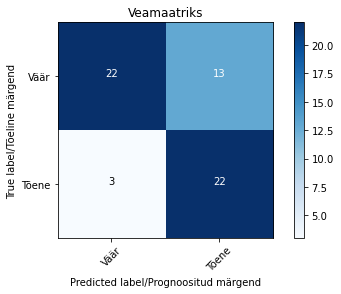

In [13]:
# Vektoriseerimine ja TF-IDF rakendamine
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer(tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Mudeli sobitamine
model = pipe.fit(X_train, y_train)

# Prognoosimine
prediction = model.predict(X_test)
print("Logistilise regressiooni mudeli ennustustäpsus: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

cm = metrics.confusion_matrix(y_test, prediction)

print("Tekst: ", txt1)
print(model.predict(txt1)[0])
print("Tekst: ", txt2)
print(model.predict(txt2)[0])
print("Tekst: ", txt3)
print(model.predict(txt3)[0])
print("Tekst: ", txt4)
print(model.predict(txt4)[0])
print("Tekst: ", txt5)
print(model.predict(txt5)[0])
print("Tekst: ", txt6)
print(model.predict(txt6)[0])
print("Tekst: ", txt7)
print(model.predict(txt7)[0])

plot_confusion_matrix(cm, classes=['Väär', 'Tõene'])

### Difference from here

In [14]:
conversion = {
    "true": 1,
    "fake": 0
}
y_train = y_train.map(conversion)
y_test = y_test.map(conversion)
y_train[:5]

169    1
97     0
31     0
12     1
35     0
Name: target, dtype: int64

In [15]:
# TF-IDF vektoriseerija rakendamine
tfidf_vectorizer=TfidfVectorizer(tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)

# fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(X_train)
tfidf_test=tfidf_vectorizer.transform(X_test)

In [16]:
# just out of curiosity. Results are not so good. 
from xgboost import XGBClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "xgboost": XGBClassifier(use_label_encoder=False),
    "PAC": PassiveAggressiveClassifier(),
    "RF": RandomForestClassifier(),
    "SVC": SVC()
}

for name, model in models.items():
    model.fit(tfidf_train, y_train.values)

    # Prognoosimine
    prediction = model.predict(tfidf_test)
    print(f"{name} mudeli ennustustäpsus: {round(accuracy_score(y_test.values, prediction)*100,2)}%")

[20:22:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost mudeli ennustustäpsus: 70.0%
PAC mudeli ennustustäpsus: 76.67%
RF mudeli ennustustäpsus: 68.33%
SVC mudeli ennustustäpsus: 73.33%


In [17]:
import tensorflow as tf
from tensorflow.keras import initializers
tf.get_logger().setLevel('INFO')

def make_model(input_shape, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
              2048, activation='relu',
              input_shape=(input_shape,),
              kernel_initializer=initializers.RandomNormal(stddev=0.01),
              bias_initializer=initializers.Zeros()),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
              256, activation='relu',
              kernel_initializer=initializers.RandomNormal(stddev=0.01),
              bias_initializer=initializers.Zeros()),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
              16, activation='relu',
              kernel_initializer=initializers.RandomNormal(stddev=0.01),
              bias_initializer=initializers.Zeros()),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['binary_accuracy'])

    return model

/home/hiroki/anaconda3/envs/anne/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hiroki/anaconda3/envs/anne/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hiroki/anaconda3/envs/anne/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hiroki/anaconda3/envs/anne/lib/python3.7/site-

In [18]:
EPOCHS = 50
BATCH_SIZE = 8

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model(100)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              206848    
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
________________________________________________________

In [19]:
from sklearn.model_selection import StratifiedKFold

X, y = data['text'], data['target']
metrics = []

skf = StratifiedKFold(n_splits=10)
i = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train = y_train.map(conversion)
    y_test = y_test.map(conversion)

    tfidf_vectorizer=TfidfVectorizer(tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)
    
    X_train_dtm = tfidf_vectorizer.fit_transform(X_train)
    X_test_dtm = tfidf_vectorizer.transform(X_test)
    model = make_model(X_train_dtm.shape[-1])
    model.fit(
        X_train_dtm,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = [early_stopping],
        verbose=0,
        validation_data=(X_test_dtm, y_test))

    metrics.append(model.evaluate(X_test_dtm, y_test)[1])


metrics = np.array(metrics)
print('Mudelite täpsused: ', metrics)
print('Mudeli keskmine täpsus (accuracy): ', round(np.mean(metrics, axis=0)*100,2), "%")

Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
20/20 [==============================] - 0s 423us/sample - loss: 0.5341 - binary_accuracy: 0.9500
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
20/20 [==============================] - 0s 416us/sample - loss: 0.5836 - binary_accuracy: 0.9000
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
20/20 [==============================] - 0s 559us/sample - loss: 0.5319 - binary_accuracy: 0.9500
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
20/20 [==============================] - 0s 396us/sample - loss: 0.5851 - binary_accuracy: 0.9500
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
20/20 [==============================] - 0s 412us/sample - loss: 0.5983 - binary_accuracy: 0.8000
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
20/20 

In [21]:
# for prediction, using the last model
pred = [1 if pred>0.5 else 0 for pred in model.predict(X_test_dtm)]
print(f"DNN mudeli ennustustäpsus: {round(accuracy_score(y_test.values, pred)*100,2)}%")

DNN mudeli ennustustäpsus: 85.0%


In [22]:
# Passiiv-agressiiv mudel 10-kordsel ristvalideerimisel

X, y = data['text'], data['target']
metrics = []

skf = StratifiedKFold(n_splits=10)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    tfidf_vectorizer=TfidfVectorizer(tokenizer = lemmatize_with_estnltk, stop_words = stopsõnad_uus)
    
    X_train_dtm = tfidf_vectorizer.fit_transform(X_train)
    X_test_dtm = tfidf_vectorizer.transform(X_test)
    pac=PassiveAggressiveClassifier(max_iter=50)
    pac.fit(X_train_dtm, y_train)
    y_pred_class = pac.predict(X_test_dtm)

    metrics.append(accuracy_score(y_test, y_pred_class))

metrics = np.array(metrics)
print('Mudelite täpsused: ', metrics)
print('Mudeli keskmine täpsus (accuracy): ', round(np.mean(metrics, axis=0)*100,2), "%")

Mudelite täpsused:  [0.85 0.75 0.95 0.8  0.85 0.85 0.8  0.75 0.9  0.85]
Mudeli keskmine täpsus (accuracy):  83.5 %
